<a href="https://colab.research.google.com/github/mkhaleghian/SevenStates/blob/main/Analysis_7sates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
from google.colab import drive
import datetime


In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/7_states/Session-Details-Summary-20240119-3.xlsx')

Mounted at /content/drive


In [5]:
missing_count = df['Port Type'].value_counts().get('Missing', 0)
print(f"Number of missing values in 'Port Type': {missing_count}")

Number of missing values in 'Port Type': 0


In [6]:
unique_values_time_zone = df['Start Time Zone'].unique()
print(unique_values_time_zone)

['EST' 'CST' 'PST' 'CDT' 'EDT' 'PDT']


In [7]:
# Convert Start and End Date to datetime
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

def convert_to_est(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


# Apply function to Start and End Date
df['Start_Time_EST'] = df.apply(convert_to_est, args=('Start Date', 'Start Time Zone'), axis=1)
df['End_Time_EST'] = df.apply(convert_to_est, args=('End Date', 'End Time Zone'), axis=1)

In [8]:
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2].split()[0])  # Extract seconds and ignore 'AM' or 'PM'
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return total_seconds
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0  # Handle other cases if needed

In [9]:
# Assuming 'Total Duration' is in string format '1:26:32 AM'
df['Total Duration'] = df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds)
df['Charging Time'] = df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds)

In [10]:
count = (df['Charging Time'] > df['Total Duration']).sum()
count

107

In [11]:
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']

In [12]:
df['Time_Difference'] = df['Total Duration'] - df['Charging Time']


In [13]:
df['Time_Difference'].describe()

count    38624.000000
mean      1426.306804
std       5571.574125
min          0.000000
25%         20.000000
50%         35.000000
75%        117.000000
max      75828.000000
Name: Time_Difference, dtype: float64

In [14]:
count_117 = (df['Time_Difference'] > 117).sum()
count_15_min_more = (df['Time_Difference'] > 900).sum()
count_60_min_more = (df['Time_Difference'] > 3600).sum()

print(f"Number of charging time with more than 117 sec: {count_117}")
print(f"Number of charging time with more than 900 sec- 15min: {count_15_min_more}")
print(f"Number of charging time with more than 3600 sec- 60min: {count_60_min_more}")

Number of charging time with more than 117 sec: 9633
Number of charging time with more than 900 sec- 15min: 4841
Number of charging time with more than 3600 sec- 60min: 3061


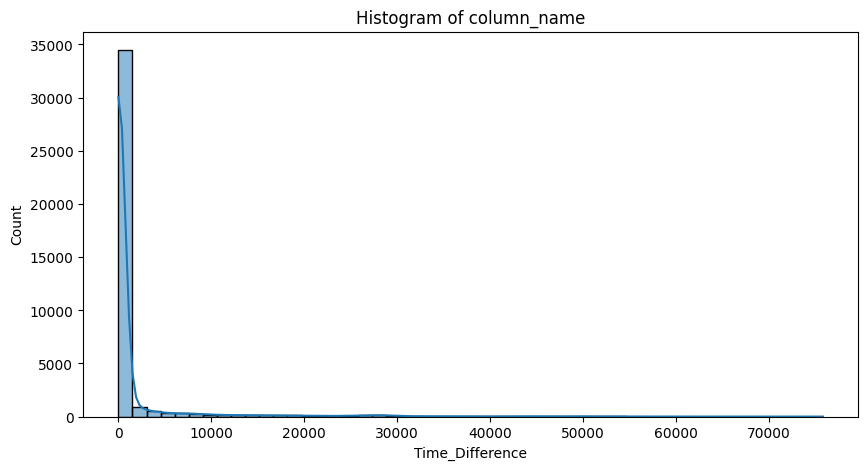

In [15]:
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['Time_Difference'], bins=50, kde=True)
plt.title('Histogram of column_name')
plt.show()



In [16]:
charging_time = df['Charging Time']
charging_time_in_hours = charging_time / 3600
charging_time_in_hours.describe()

count    38624.000000
mean         1.503110
std          2.041753
min          0.000000
25%          0.240556
50%          0.744583
75%          1.885972
max         21.887222
Name: Charging Time, dtype: float64

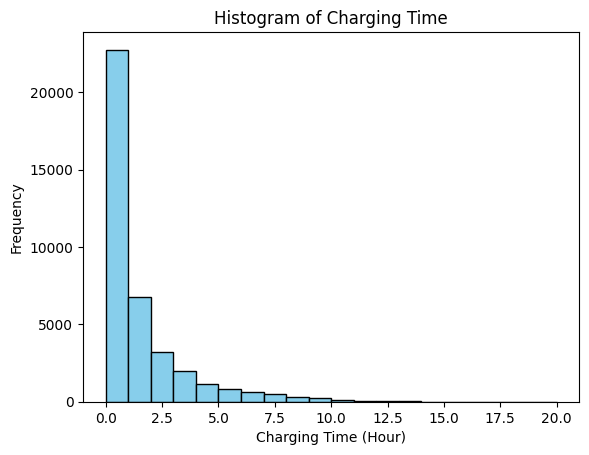

In [17]:
charging_time = df['Charging Time']

# Convert timedelta to hour for easier visualization
charging_time_in_hours = charging_time / 3600

# Plot histogram
plt.hist(charging_time_in_hours, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], color='skyblue', edgecolor='black')
plt.title('Histogram of Charging Time')
plt.xlabel('Charging Time (Hour)')
plt.ylabel('Frequency')
plt.show()

In [18]:
unique_values_port_type = df['Port Type'].unique()

# Count occurrences of each unique value
port_type_counts = df['Port Type'].value_counts()

# Print unique values
print("Unique Values:", unique_values_port_type)

# Print counts of each unique value
print("Number of charging events")
print(port_type_counts)


Unique Values: ['Level 2' 'DC Fast' nan]
Number of charging events
Level 2    21490
DC Fast    15453
Name: Port Type, dtype: int64


In [19]:
# Convert 'Start_Time_EST' to datetime if it's not already
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])

# Create a new column 'Day_of_Week' that represents the day of the week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

In [20]:
# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)

In [21]:
df['Port Type'] = df['Port Type'].fillna('')

df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]


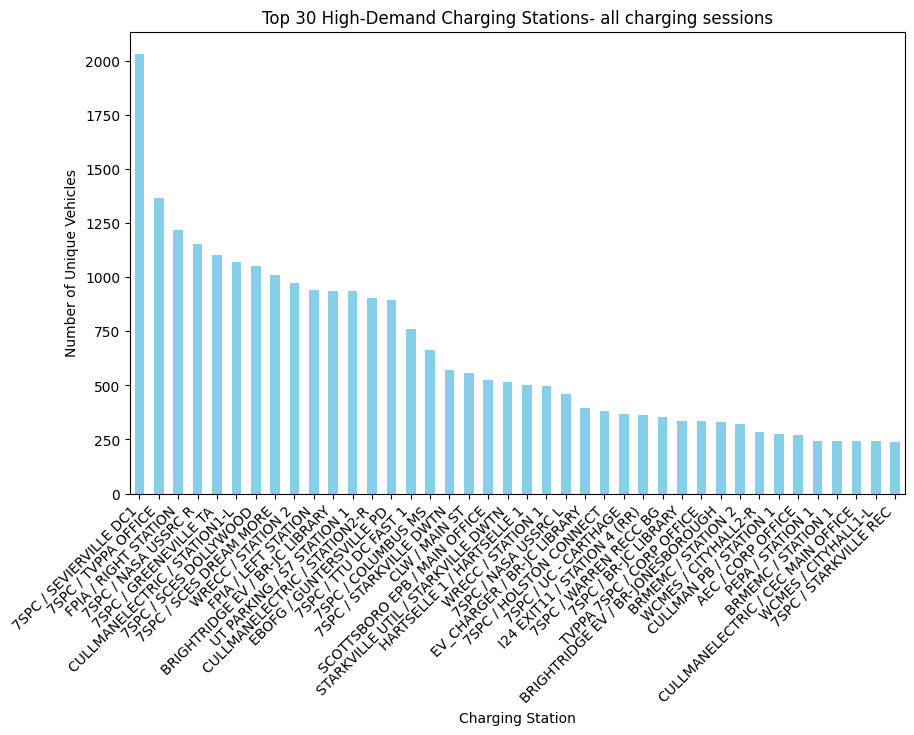

In [22]:
vehicles_per_station_all = df.groupby('Station Name')['User ID'].count()
top_30_stations_all = vehicles_per_station_all.sort_values(ascending=False).head(40)

# Plotting
plt.figure(figsize=(10, 6))
top_30_stations_all.plot(kind='bar', color='skyblue')
plt.title('Top 30 High-Demand Charging Stations- all charging sessions')
plt.xlabel('Charging Station')
plt.ylabel('Number of Unique Vehicles')
plt.xticks(rotation=45, ha='right')
plt.show()

**Take a look at the highest demand CS**

```
# This is formatted as code
```



<ipython-input-32-a3500b718b36>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_december_2023['Duration (hours)'] = (
<ipython-input-32-a3500b718b36>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab20', len(df_december_2023['User ID'].unique()))


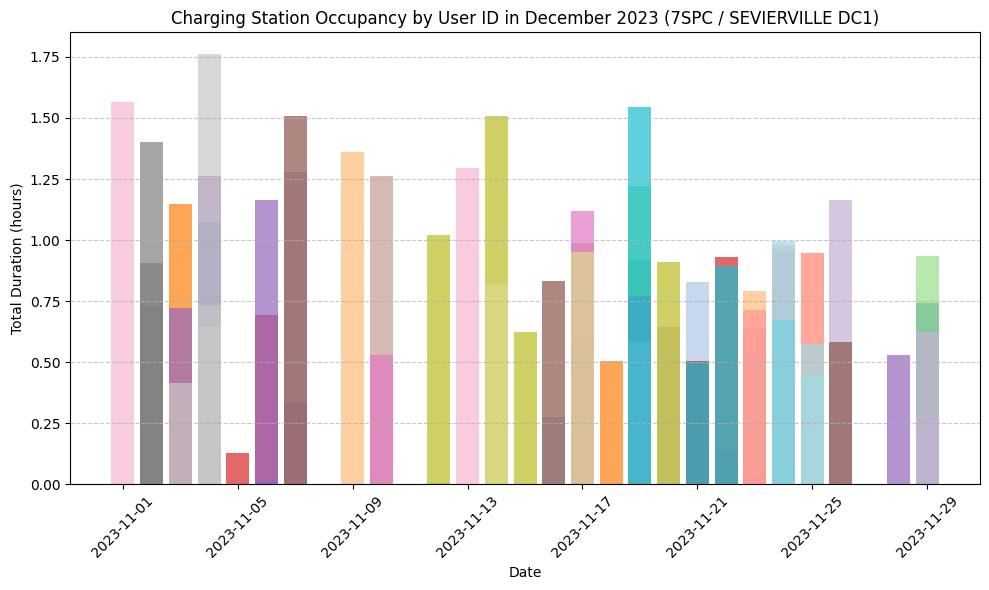

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' containing charging session data
# with columns 'Start_Time_EST', 'End_Time_EST', 'User ID', and 'Duration (hours)'

# Filter data for the specified charging station and month
df_station_SEVIERVILLE_DC1 = df[df['Station Name'] == "7SPC / SEVIERVILLE DC1"]
df_december_2023 = df_station_SEVIERVILLE_DC1[
    (df_station_SEVIERVILLE_DC1['Start_Time_EST'].dt.month == 11) &  # December
    (df_station_SEVIERVILLE_DC1['Start_Time_EST'].dt.year == 2023)    # Year 2023
]

# Calculate session durations in hours
df_december_2023['Duration (hours)'] = (
    (df_december_2023['End_Time_EST'] - df_december_2023['Start_Time_EST'])
    .dt.total_seconds() / 3600
)

# Create a bar chart with different colors for each user
plt.figure(figsize=(10, 6))
color_palette = plt.cm.get_cmap('tab20', len(df_december_2023['User ID'].unique()))
for i, (user_id, user_data) in enumerate(df_december_2023.groupby('User ID')):
    plt.bar(user_data['Start_Time_EST'].dt.date, user_data['Duration (hours)'],
            color=color_palette(i), alpha=0.7, label=f'User {user_id}')

plt.xlabel('Date')
plt.ylabel('Total Duration (hours)')
plt.title('Charging Station Occupancy by User ID in December 2023 (7SPC / SEVIERVILLE DC1)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [44]:
import pandas as pd

# Assuming you have a DataFrame 'df' containing charging session data
# with columns 'Start_Time_EST', 'End_Time_EST', 'User ID', and 'Charging Time' (in seconds)

# Filter data for the specified charging station and month
df_station_SEVIERVILLE_DC1 = df[df['Station Name'] == "7SPC / SEVIERVILLE DC1"]

# Group by day and count unique User IDs
daily_summary = df_station_SEVIERVILLE_DC1.groupby(df_station_SEVIERVILLE_DC1['Start_Time_EST'].dt.date).agg(
    {'User ID': 'nunique', 'Charging Time': 'sum'}
).rename(columns={'User ID': 'Unique Users', 'Charging Time': 'Total Hours'})

# Convert total hours from seconds to hours
daily_summary['Total Hours'] = daily_summary['Total Hours'] / 3600

# Display the resulting DataFrame
print(daily_summary)



                Unique Users  Total Hours
Start_Time_EST                           
2021-08-16                 1     1.110278
2021-08-23                 1     0.315833
2021-08-27                 1     1.213889
2021-08-28                 1     0.455556
2021-08-30                 1     0.157500
...                      ...          ...
2024-01-15                 2     1.206944
2024-01-16                 2     1.903056
2024-01-17                 3     4.684167
2024-01-18                 2     2.596111
2024-01-19                 3     1.679722

[734 rows x 2 columns]


In [51]:
import pandas as pd

# Assuming df is your original dataframe
df['Start Date'] = pd.to_datetime(df['Start Date']).dt.date  # Ensure 'Start Date' is in date format

# Group by 'Station Name' and 'Start Date', then calculate the unique 'User ID' and sum of 'Charging Time'
new_df = df.groupby(['Station Name', 'Start Date']).agg({'User ID': pd.Series.nunique, 'Charging Time': 'sum'}).reset_index()

# Rename the columns
new_df.columns = ['Station Name', 'Date', 'Unique User Count', 'Total Charging Time']




In [68]:

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST']).dt.date

new_df = df.groupby(['Station Name', 'Start_Time_EST']).agg({'User ID': 'count', 'Charging Time': 'sum', 'Total Duration':'sum', 'Energy (kWh)':'sum',
                                                             'Gasoline Savings (gallons)':'sum','GHG Savings (kg)':'sum', 'Fee':'sum'}).reset_index()


new_df['Charging Time'] = new_df['Charging Time'] / 3600
new_df['Total Duration'] = new_df['Total Duration'] / 3600

new_df.columns = ['Station Name', 'Date', 'User Count', 'Total Charging Time (hours)', 'Total Duration Time (hours)','Total Energy', 'Total Gasoline Savings (gallons)',
                  'Total GHG Savings (kg)', 'Total Fee']


In [72]:

new_df.to_excel('/content/drive/MyDrive/Colab Notebooks/new_dataframe_Day_by_day.xlsx', index=False)
